# <span style="color:#4174B9">Baseball Statistics</span>

Baseball started in United States in the 1700s and 1800s. It is called the national pastime, because so many people in the United States used to spend a lot of time playing or watching baseball games. Today, though, most Americans follow football more than baseball, especially when its time for the Super Bowl. Baseball is a game of statistics. Since the flow of a baseball game has natural breaks to it, and normally players act individually rather than performing in clusters, the sport lends itself to easy record-keeping and statistics. Statistics have been kept for professional baseball since the creation of the National League and American League, now part of Major League Baseball. The importance of statistics in baseball increased with the advent of free agency in 1974. Statistics beacame vital information in determining individual salary, with the free agent market clearly setting what each player should be paid for his given statistics.

Baseball statistics are used in evaluating a player's and/or a team's performance. The following analysis is based on baseball data made available by Sean Lahman, an award-winning database journalist and author. The data can be downloaded from his [website](http://www.seanlahman.com/baseball-archive/statistics/). Let us start by exploring the player salararies.

## <span style="color:#117A65">Analysis of MLB payrolls</span>

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib as mpl
import seaborn as sns

# Set display properties
%pylab inline
sns.set_style('white')
pd.options.display.max_rows = 8
pd.options.display.max_columns = 15

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read data from csv file into pandas dataframe
def read_csv(filename):
    # The argument to this function is the filename of csv file
    path = './baseballdatabank-master/core/'
    data = pd.read_csv(path + filename, sep=',', keep_default_na=False, na_values=[''])
    print filename, 'has', data.shape[0], 'rows and', data.shape[1], 'columns'
    return data

In [3]:
# Format summary statistics of salary
def format_salary(x):
    return r'$%1.2fM' % (x*1e-6)

In [4]:
# Read in the salary details
salaries = read_csv('Salaries.csv')

Salaries.csv has 25575 rows and 5 columns


In [5]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25575 entries, 0 to 25574
Data columns (total 5 columns):
yearID      25575 non-null int64
teamID      25575 non-null object
lgID        25575 non-null object
playerID    25575 non-null object
salary      25575 non-null int64
dtypes: int64(2), object(3)
memory usage: 999.1+ KB


In [6]:
print salaries.head(), '\n'
print 'Data from', salaries.yearID.min(), 'to', salaries.yearID.max()

   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000 

Data from 1985 to 2015


### Distribution of players salary over time

In [7]:
# Salary Stats
def yearly_stats(groupby):
    # The argument to this function is the column name by which data needs to be grouped: ['playerID', 'teamID']
    cols = ['yearID']
    cols.append(groupby)
    s = salaries.groupby(cols, as_index=False).sum()
    s = s.groupby('yearID').agg({"salary": {"max_salary" : np.max,
                                            "avg_salary" : np.mean,
                                            "median_salary" : np.median,
                                            "min_salary" : np.min}})
    s.columns = s.columns.get_level_values(1)
    return s

In [8]:
yearly_salary_stats = yearly_stats('playerID')
yearly_payroll_stats = yearly_stats('teamID')

In [9]:
# Format salary labels to make them concise in plots
def millions(x, pos):
    # The two args are the value and tick position
    return format_salary(x)

formatter = FuncFormatter(millions)

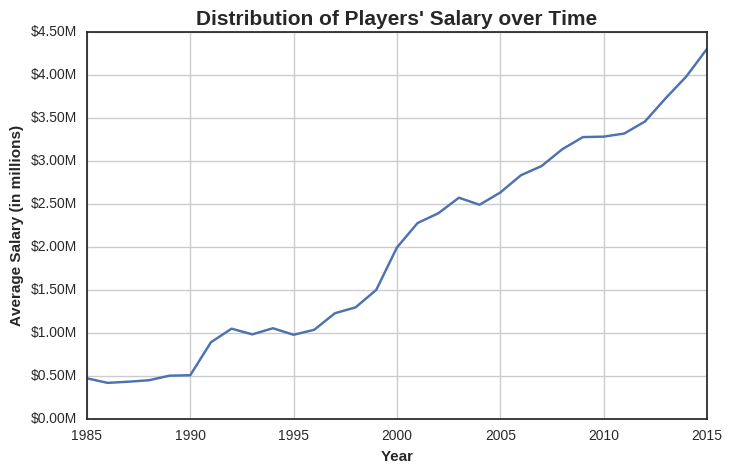

In [10]:
# Plot average annual salary vs year
f, ax = plt.subplots()
f.set_size_inches((8,5))

plt.plot(yearly_salary_stats.index, yearly_salary_stats.avg_salary, label='Avg. Player Salary')
ax.yaxis.set_major_formatter(formatter)

plt.title("Distribution of Players' Salary over Time", fontsize=15, weight='bold')
plt.xlabel("Year", weight='bold')
plt.ylabel("Average Salary (in millions)", weight='bold')

plt.grid()

Average yearly salary of a player has an increasing trend with time. There are some up's and down's which coincide with some of the major events in baseball history. For example, the abrupt increase from 1990 to 1991 coincides with [1990 Major League Baseball lockout](https://en.wikipedia.org/wiki/1990_Major_League_Baseball_lockout) which was resolved by raising minimum major league salary from \$68,000 to \$100,000. The period 1993-95 has a non-increasing trend. During this period, a dispute played out between the players and the ownership regarding the proposal of salary-cap which led to the [1994–95 Major League Baseball strike](https://en.wikipedia.org/wiki/1994%E2%80%9395_Major_League_Baseball_strike). As a result of this strike, the 1994 World series was canceled. Post-strike years has an ever increasing trend. There is a small dip in the year 2004 which coincides with the announcement of a [new drug policy](https://en.wikipedia.org/wiki/List_of_Major_League_Baseball_players_suspended_for_performance-enhancing_drugs) in Jan 2004 which led to the suspension of many MLB players for the use of performance-enhancing drugs.

In [11]:
yearly_salary_stats.avg_salary.describe().iloc[1:].apply(format_salary)

mean    $1.98M
std     $1.22M
min     $0.42M
25%     $0.98M
50%     $2.00M
75%     $3.04M
max     $4.30M
Name: avg_salary, dtype: object

The average player salary has increased by 800% from \$0.5M in 1985 to \$4.3M in 2015. Let us look at the distribution of amount spent by teams on payrolls over time.

### Distribution of Team payrolls over time

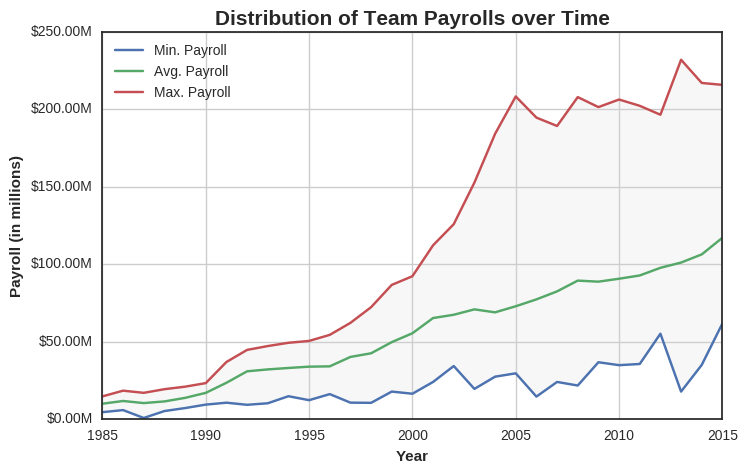

In [12]:
# Plot average annual payroll vs year
f, ax = plt.subplots()
f.set_size_inches((8,5))

plt.plot(yearly_payroll_stats.index, yearly_payroll_stats.min_salary, label='Min. Payroll')
plt.plot(yearly_payroll_stats.index, yearly_payroll_stats.avg_salary, label='Avg. Payroll')
plt.plot(yearly_payroll_stats.index, yearly_payroll_stats.max_salary, label='Max. Payroll')

ax.fill_between(yearly_payroll_stats.index, yearly_payroll_stats.min_salary,
                yearly_payroll_stats.max_salary, alpha=0.2, color='0.85')
ax.yaxis.set_major_formatter(formatter)

plt.title("Distribution of Team Payrolls over Time", fontsize=15, weight='bold')
plt.xlabel("Year", weight='bold')
plt.ylabel("Payroll (in millions)", weight='bold')
plt.legend(loc='best')

plt.grid()

Team payrolls have an interesting trend over time. The maximum amount spent on payrolls increases more steeply than the minimum amount. During 1985-90, the increase is very low, and the range of salaries is almost constant. From 1991 to 2005 the maximum amount spent on payroll increased steeply while the increase in the minimum amount spent is very low. Moreover, this increasing trend in maximum payroll is absent after 2005. Let us look at the spread of payroll amounts for individual teams to find possible reasons for this trend.

In [13]:
# Yearly payroll of teams
yearly_payroll = salaries.groupby(['teamID', 'yearID'], as_index=False).sum()

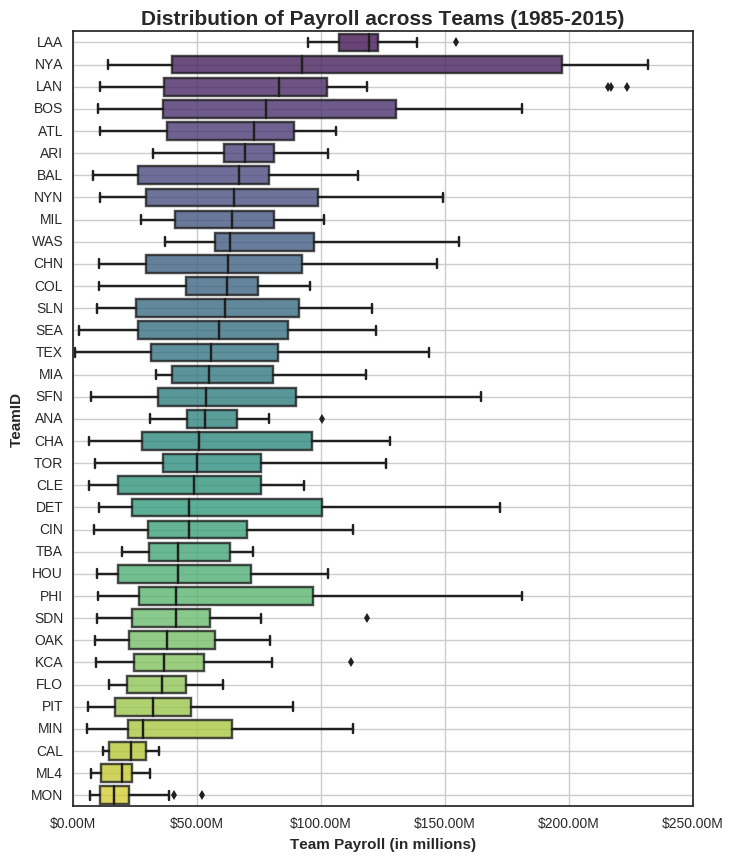

In [14]:
# Spread of amount spent by individual teams on payroll
plt.figure(figsize=(8,10))

order = yearly_payroll.groupby('teamID').median().sort_values(by='salary', ascending=False).index
g = sns.boxplot(data=yearly_payroll, x='salary', y='teamID', order=order, palette='viridis')

plt.setp(g.artists, alpha=0.8)
g.xaxis.set_major_formatter(formatter)
g.set_title("Distribution of Payroll across Teams (1985-2015)", fontsize=15, weight='bold')
g.set_xlabel("Team Payroll (in millions)", weight='bold')
g.set_ylabel("TeamID", weight='bold')

g.grid()

The boxplot clearly shows that not all teams spend equally on their payrolls. For example, the minimum amount spent by Los Angeles Angels of Anaheim (LAA) is higher than the median amount of all individual teams. A possible explanation for the observed trend can be that some teams can spend huge amounts on the payroll to hire the best talent while others cannot support the best players financially. How can we test this hypothesis? If our hypothesis is true then the team's payroll should translate to teams performance in regular season and post-season. We test our hypothesis by performing regression analysis relating regular season and post-season success to team payroll.

In [15]:
# Read in team details
teams = read_csv('Teams.csv') #Regular season details
teams_post = read_csv('SeriesPost.csv') #Post-Season details

Teams.csv has 2805 rows and 48 columns
SeriesPost.csv has 307 rows and 9 columns


In [16]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 48 columns):
yearID            2805 non-null int64
lgID              2805 non-null object
teamID            2805 non-null object
franchID          2805 non-null object
divID             1288 non-null object
Rank              2805 non-null int64
G                 2805 non-null int64
Ghome             2406 non-null float64
W                 2805 non-null int64
L                 2805 non-null int64
DivWin            1260 non-null object
WCWin             624 non-null object
LgWin             2777 non-null object
WSWin             2448 non-null object
R                 2805 non-null int64
AB                2805 non-null int64
H                 2805 non-null int64
2B                2805 non-null int64
3B                2805 non-null int64
HR                2805 non-null int64
BB                2805 non-null int64
SO                2685 non-null float64
SB                2661 non-null float64
CS    

In [17]:
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,...,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NA,BS1,BNA,NaN,3,31,...,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NA,CH1,CNA,NaN,2,28,...,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NA,CL1,CFC,NaN,8,29,...,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NA,FW1,KEK,NaN,7,19,...,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NA,NY2,NNA,NaN,5,33,...,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [18]:
# Add salary data into team details
teams = teams.merge(yearly_payroll, on=['teamID', 'yearID'], how='left')

In [19]:
# Calculate Regular season winning percentage
teams['win_percent'] = (teams.W / teams.G) * 100

In [20]:
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,...,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,salary,win_percent
0,1871,NA,BS1,BNA,NaN,3,31,...,103,98,BOS,BS1,BS1,NaN,64.516129
1,1871,NA,CH1,CNA,NaN,2,28,...,104,102,CHI,CH1,CH1,NaN,67.857143
2,1871,NA,CL1,CFC,NaN,8,29,...,96,100,CLE,CL1,CL1,NaN,34.482759
3,1871,NA,FW1,KEK,NaN,7,19,...,101,107,KEK,FW1,FW1,NaN,36.842105
4,1871,NA,NY2,NNA,NaN,5,33,...,90,88,NYU,NY2,NY2,NaN,48.484848


In [21]:
teams_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 9 columns):
yearID          307 non-null int64
round           307 non-null object
teamIDwinner    307 non-null object
lgIDwinner      307 non-null object
teamIDloser     307 non-null object
lgIDloser       307 non-null object
wins            307 non-null int64
losses          307 non-null int64
ties            307 non-null int64
dtypes: int64(4), object(5)
memory usage: 21.7+ KB


In [22]:
teams_post.head()

,yearID,round,teamIDwinner,lgIDwinner,teamIDloser,lgIDloser,wins,losses,ties
0,1884,WS,PRO,NL,NYP,AA,3,0,0
1,1885,WS,CHC,NL,STL,AA,3,3,1
2,1886,WS,STL,AA,CHC,NL,4,2,0
3,1887,WS,DTN,NL,STL,AA,10,5,0
4,1888,WS,NYG,NL,STL,AA,6,4,0


In [23]:
# Reshape post-season details to calculate winning percentage
games_won = teams_post.groupby(['teamIDwinner','yearID']).sum()
games_lost = teams_post.groupby(['teamIDloser','yearID']).sum()

playoffs = pd.concat([games_won, games_lost], axis=0).reset_index()
playoffs.columns = ['teamID', 'yearID', 'post_W', 'post_L', 'post_T']

playoffs['post_G'] = playoffs.post_W + playoffs.post_L + playoffs.post_T

playoffs = playoffs.groupby(['teamID', 'yearID']).sum().reset_index()

In [24]:
# Add salary data into the post-season details
playoffs = playoffs.merge(yearly_payroll, on=['teamID', 'yearID'], how='left', copy=False)

In [25]:
# Calculate post-season winning percentage
playoffs['post_win_percent'] = (playoffs.post_W / playoffs.post_G) *100
playoffs.head()

,teamID,yearID,post_W,post_L,post_T,post_G,salary,post_win_percent
0,ANA,2002,11,5,0,16,61721667.0,68.750000
1,ANA,2004,3,0,0,3,100534667.0,100.000000
2,ARI,1999,3,1,0,4,68703999.0,75.000000
3,ARI,2001,11,6,0,17,85082999.0,64.705882
4,ARI,2002,3,0,0,3,102819999.0,100.000000


In [26]:
# Linear regression of winning percentage and amount spent on payroll
def payroll_reg(df, s):
    # The two arguments to this function dataframe and season type {'rs'for Regular Season and 'ps'for Post-Season}
    
    # Dicts for case specific values
    # column containing win percentage
    y = {'rs': 'win_percent', 'ps': 'post_win_percent'}
    # title of the plot
    t = {'rs': 'Regular Season %Wins Vs Payroll (1985-2015)', 'ps': 'Post-Season %Wins Vs Payroll (1985-2015)'}
    # color for the plot
    c = {'rs': sns.color_palette()[5], 'ps': sns.color_palette()[3]}
    
    g = sns.lmplot(data=df, x='salary', y=y[s], size=5, aspect=1.5,
                   scatter_kws={'color': c[s]}, line_kws={'color': c[s]})

    g.fig.suptitle(t[s], fontsize=15, weight='bold')
    g.set_xlabels("Payroll (in millions)", weight='bold')
    g.set_ylabels("%Wins", weight='bold')
    sns.despine(right=False, top=False)
    
    # Linear regression using scipy.stats
    mask = ~pd.isnull(df['salary']) & ~pd.isnull(df[y[s]])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=df['salary'][mask]*1e-6,
                                                                   y=df[y[s]][mask])
    g.ax.xaxis.set_major_formatter(formatter)
    
    #Add regression summary to plots
    g.ax.text(0.01, 0.935,
              r"$R^2={r}$".format(r='%.2g'%r_value**2) + "\n"
              r"$r={r}, \thinspace p={p}$".format(r='%.2g'%r_value, p='%.2g'%p_value) + "\n" + 
              r"$y={m}x+{c}$".format(m=round(slope,2), c=round(intercept,2)),
              ha='left', va='top',
              transform = g.ax.transAxes, fontsize=12)

    g.ax.grid()

    g.fig.tight_layout(rect=[0, 0, 1, 0.97])

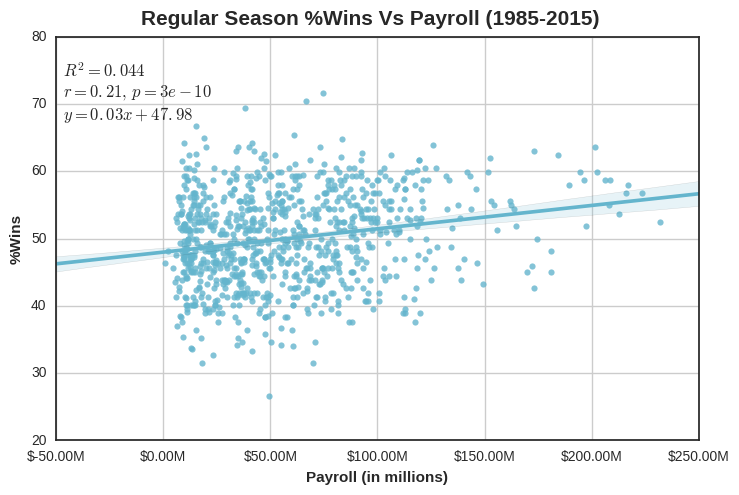

In [27]:
payroll_reg(teams, 'rs')

Based on the data at hand on team payrolls and regular season wins, a regression analysis relating percentage wins to team payroll suggests a positive relationship. The p-value for the slope suggests a statistically significant relationship. The coefficient for payroll suggests that every \$30000 spent on payroll increases regular season wins by 1%. As expected, we found a statistically significant positive relationship with the $R^2$ value of 0.044. The result suggests that the free agency market is partly responsible for the competitive imbalance in the regular season.

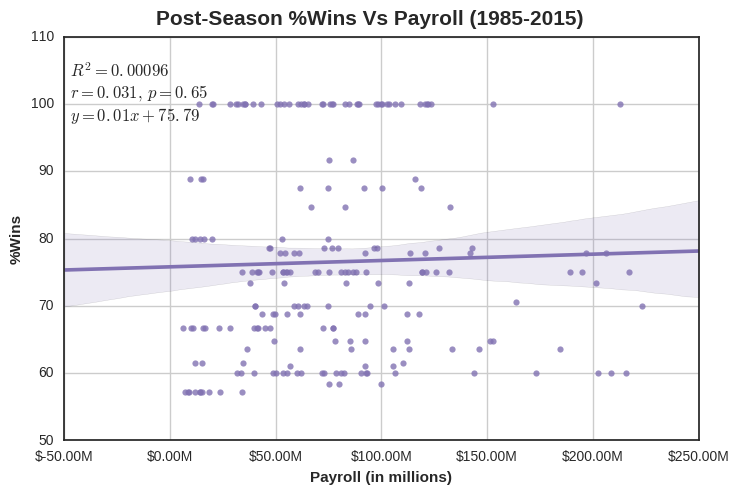

In [28]:
payroll_reg(playoffs, 'ps')

In our analysis of post-season wins, the result of the regression analysis is not as expected. The results suggest statistically insignificant relationship between percentage wins and payroll. It suggests that a short post-season is a random event in which team payroll has a negligible effect on wins. Before we proceed further with our analysis, let us summarize our finding.

The results of the regression analysis suggest that team payroll has a significant impact on success in the regular season due to free agency market. The ability to purchase talent in the open market and a 162 game season over six months diminishes the random elements leading to expected effects of team payroll on regular season winning percentage. While conventional wisdom leads us to think that teams have the ability to "buy" championships in baseball because there is no salary-cap, our analysis does not support this claim. We did not find a statistically significant relationship between post-season wins and team payroll.

Following our results, let us look at the team metrics which correlate with team wins in a regular season.

## <span style="color:#117A65">Analysis of Team Metrics</span>

In [29]:
# Create a correlation clustermap
def draw_clustermap(df, fmt=None):
    # Remove ordinal columns
    non_ordinal_cols = [col for col in df.columns if col not in ['yearID', 'Rank']]

    # Compute the correlation matrix
    corr = df[non_ordinal_cols].corr()
    
    # Plot a clustermap using correlation as a distance metric
    g = sns.clustermap(corr, cmap='Spectral', linewidths=.5, metric='correlation', annot=(fmt!=None), fmt=fmt)
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()

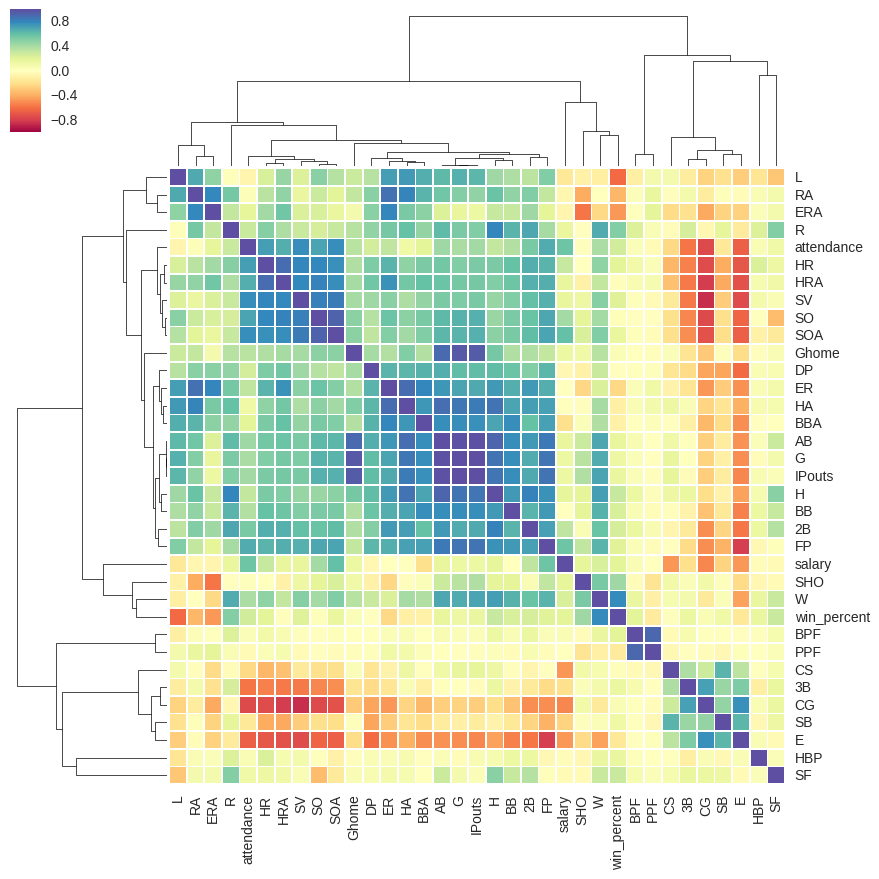

In [30]:
# Clustermap of team metrics
draw_clustermap(teams)

As we have a large number of metrics in our dataset, let us split them into categories for ease of analysis. The categories into which we divide the metrics are the following:
1. Offense
2. Defence
3. Miscellaneous

In [31]:
Offense = ['R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'HBP', 'SF', 'CS']
Defense = ['RA', 'ER', 'ERA', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'SV', 'SHO', 'CG', 'FP', 'DP']
Misc = ['G', 'Ghome', 'salary', 'win_percent']

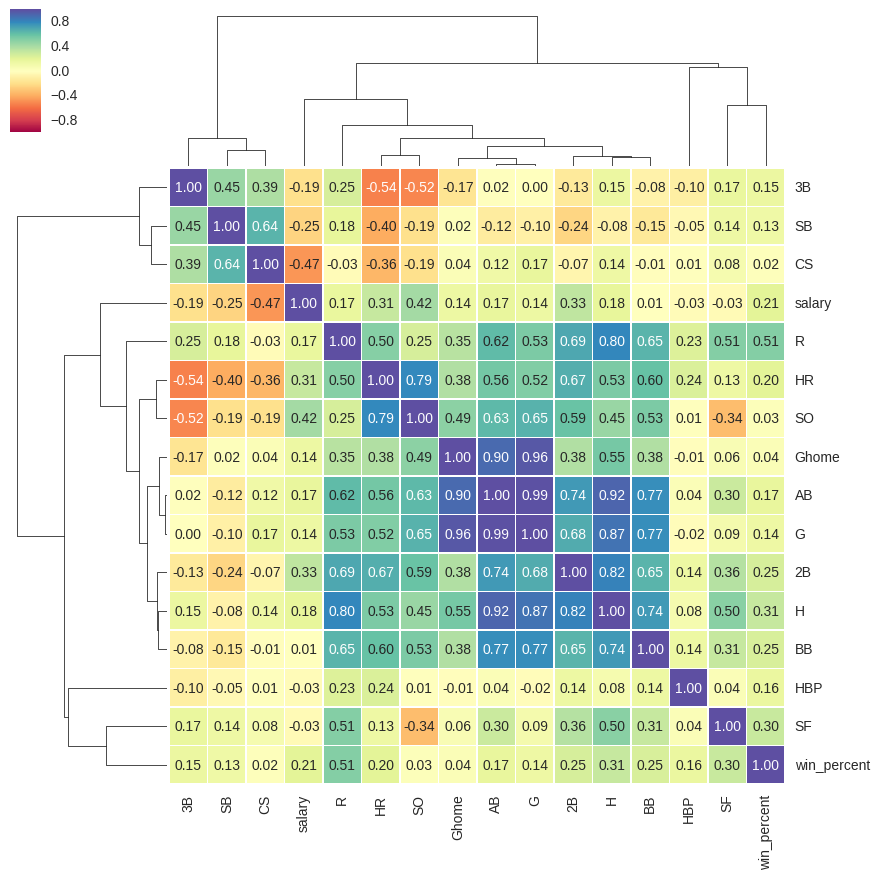

In [32]:
# Clustermap of Offense metrics
draw_clustermap(teams[Offense + Misc], '.2f')

The clustermap of offense metrics suggests that team wins (win_percent) have the highest positive correlation with Runs scored (R). And, Runs scored are highly correlated with Hits (H), At-Bats(AB), Doubles(2B), Base on Balls (BB), Home Runs (HR) and Sacrifice Flies (SF). Hits and At-Bats create opportunities to score runs. Doubles, Base on Balls, Home Runs and Sacrifice Flies are positive outcomes of the opportunities which aid scoring a run.

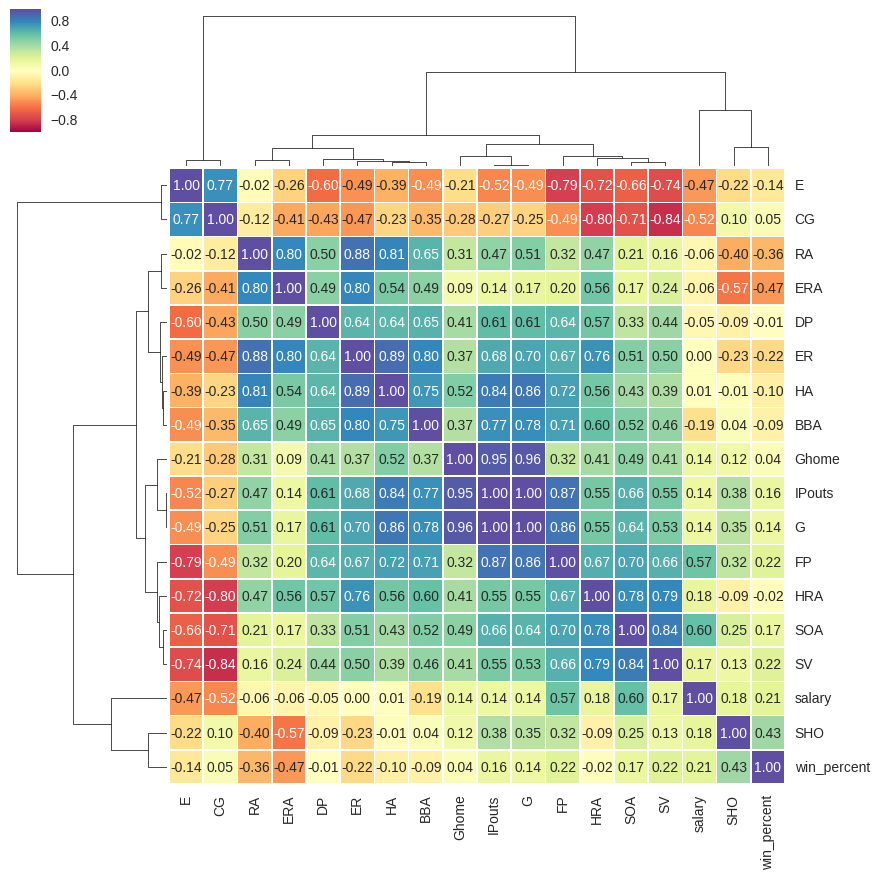

In [33]:
# Clustermap of Defense metrics
draw_clustermap(teams[Defense + Misc], '.2f')

The clustermap for defense metrics suggests that Earned Run Average (ERA) has the highest negative correlation with team wins. ERA represents the number of earned runs a pitcher allows per nine innings. Next to ERA, Runs Allowed (RA) has highest negative correlation with wins. Also, there is a positive relationship between wins and Shutouts (SHO).

Based on our observations from the correlation clustermaps for offense and defense metrics, we find that teams wins are positively related to Runs Scored and negatively related to Runs Allowed. This is as expected because to win, a team has to score more runs while playing offense than runs allowed while playing defense.

In [34]:
# Difference in Runs scored and Runs Allowed
teams['R-RA'] = teams.R - teams.RA

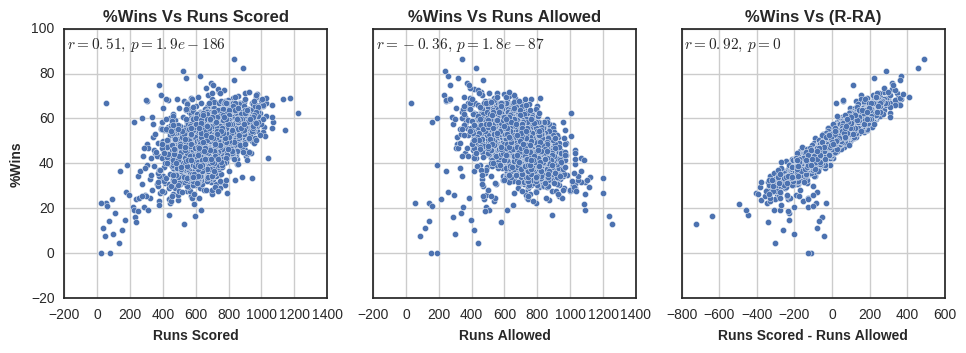

In [35]:
# Plot team winning percent in regular season vs Runs scored, Runs allowed and their difference
g = sns.pairplot(data=teams, x_vars=['R','RA','R-RA'], y_vars=['win_percent'])

g.fig.set_size_inches((10,4))
sns.despine(top=False, right=False)
g.axes[0,0].set_ylabel("%Wins", weight='bold', fontsize=10)

title = {0: "%Wins Vs Runs Scored", 1: "%Wins Vs Runs Allowed", 2: "%Wins Vs (R-RA)"}
x_label = {0: "Runs Scored", 1: "Runs Allowed", 2: "Runs Scored - Runs Allowed"}
linregress = {0: stats.linregress(x=teams['R'], y=teams['win_percent']),
              1: stats.linregress(x=teams['RA'], y=teams['win_percent']),
              2: stats.linregress(x=teams['R-RA'], y=teams['win_percent'])}

for i in range(3):
    g.axes[0,i].grid()
    g.axes[0,i].set_title(title[i], weight='bold', fontsize=12)
    g.axes[0,i].set_xlabel(x_label[i], weight='bold', fontsize=10)
    
    slope, intercept, r_value, p_value, std_err = linregress[i]
    
    g.axes[0,i].plot()
    g.axes[0,i].text(0.01, 0.97,
                  r"$r={r}, \thinspace p={p}$".format(r='%.2g'%r_value, p='%.2g'%p_value),
                  ha='left', va='top',
                  transform = g.axes[0,i].transAxes, fontsize=11)

The above plots help in visualizing our findings from clustermaps. Team wins in the regular season are highly correlated $(r=0.92)$ with the difference between Runs scored and Runs allowed.

The aim in the regular season is to make playoffs. Based on our observation on the correlation between wins and $(R-RA)$, let us find the number of wins needed to make playoffs and also the difference in runs scored and runs allowed $(R-RA)$ to win the required number of games. The [format of MLB post-season](https://en.wikipedia.org/wiki/Major_League_Baseball_postseason#Format_history) has undergone multiple changes over time in order to reduce the possibility of best teams in a league to be left out of the postseason. To account for these changes, let us split the data into periods based on post-season format and analyze if there is an significant difference across periods in team wins needed to make playoffs.

In [36]:
# Merge playoff data with team details
teams = teams.merge(playoffs, on=['teamID','yearID'], how='left')

In [37]:
# Create a column with 1 for making playoff and 0 otherwise
teams['playoffs'] = teams.post_G.map(lambda x: 0 if pd.isnull(x) else 1)
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,...,post_W,post_L,post_T,post_G,salary_y,post_win_percent,playoffs
0,1871,NA,BS1,BNA,NaN,3,31,...,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1871,NA,CH1,CNA,NaN,2,28,...,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1871,NA,CL1,CFC,NaN,8,29,...,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1871,NA,FW1,KEK,NaN,7,19,...,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1871,NA,NY2,NNA,NaN,5,33,...,NaN,NaN,NaN,NaN,NaN,NaN,0


In [38]:
# Add column to filter data based on post-season format
def mlb_postseason_format(x):
    # One Round - World Series (WS)
    if x < 1969:
        return 'Before 1969'
    # Two Round - WS + League Championship Series (LCS)
    elif x < 1994:
        return '1969-1993'
    # Three Rounds - WS + LCS + Division Series (DS) with one wildcard team
    elif x < 2012:
        return '1994-2011'
    # Expanded Wildcard - WS + LCS + DS with two wildcard teams
    else:
        return '2012-Present'

In [39]:
teams['ps_format_period'] = teams.yearID.apply(mlb_postseason_format)

In [40]:
periods = teams.ps_format_period.unique()

d = teams[teams.playoffs == 1]

W_groups = {k: d[d.ps_format_period == k]['W'] for k in periods}
R_groups = {k: d[d.ps_format_period == k]['R-RA'] for k in periods}

print "Results of One way Anova for Wins"
print stats.f_oneway(W_groups[periods[0]], W_groups[periods[1]], W_groups[periods[2]], W_groups[periods[3]])

print "\nResults of One way Anova for R-RA"
print stats.f_oneway(R_groups[periods[0]], R_groups[periods[1]], R_groups[periods[2]], R_groups[periods[3]])

Results of One way Anova for Wins
F_onewayResult(statistic=7.5817082933683171, pvalue=6.031647492167738e-05)

Results of One way Anova for R-RA
F_onewayResult(statistic=41.228117538079914, pvalue=2.6452565592601677e-23)


In [41]:
print 'Pair-wise t-test results'
for i in range(3):
    for j in range(i+1,4):
        print periods[i],'-',periods[j],'\n',stats.ttest_ind(W_groups[periods[i]], W_groups[periods[j]]),'\n'

Pair-wise t-test results
Before 1969 - 1969-1993 
Ttest_indResult(statistic=3.6659416880625022, pvalue=0.0003044397845877576) 

Before 1969 - 1994-2011 
Ttest_indResult(statistic=4.2531589543168797, pvalue=2.9148332550004145e-05) 

Before 1969 - 2012-Present 
Ttest_indResult(statistic=3.976856778967035, pvalue=0.00010270108283426609) 

1969-1993 - 1994-2011 
Ttest_indResult(statistic=-0.86652406351529654, pvalue=0.38707556193643644) 

1969-1993 - 2012-Present 
Ttest_indResult(statistic=-0.019443678234783865, pvalue=0.98451446073571836) 

1994-2011 - 2012-Present 
Ttest_indResult(statistic=0.9233141850613481, pvalue=0.35712208541879475) 



In [42]:
# Add column to filter data based on post-season format
def mlb_postseason_format(x):
    if x < 1969:
        return 'Before 1969'
    else:
        return '1969-Present'

In [43]:
teams['ps_format_period'] = teams.yearID.apply(mlb_postseason_format)

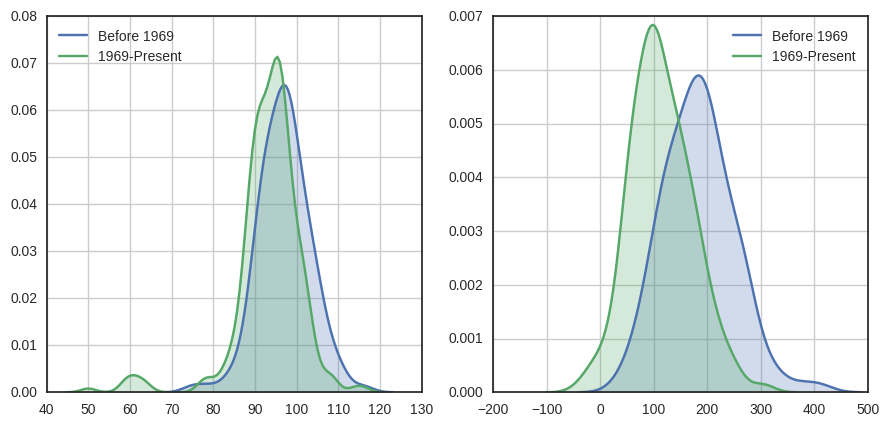

In [44]:
plt.figure(figsize=(9,4.5))

periods = teams.ps_format_period.unique()

ax1 = plt.subplot(121)
for p in periods:
    mask = (teams.ps_format_period == p) & (teams.playoffs == 1)
    d = teams[mask]
    g = sns.kdeplot(d['W'], label=p, ax=ax1, shade=True)
    g.axes.grid(True)
    

ax2 = plt.subplot(122)
for p in periods:
    mask = (teams.ps_format_period == p) & (teams.playoffs == 1)
    d = teams[mask]
    g = sns.kdeplot(d['R-RA'], label=p, ax=ax2, shade=True)
    g.axes.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.97])

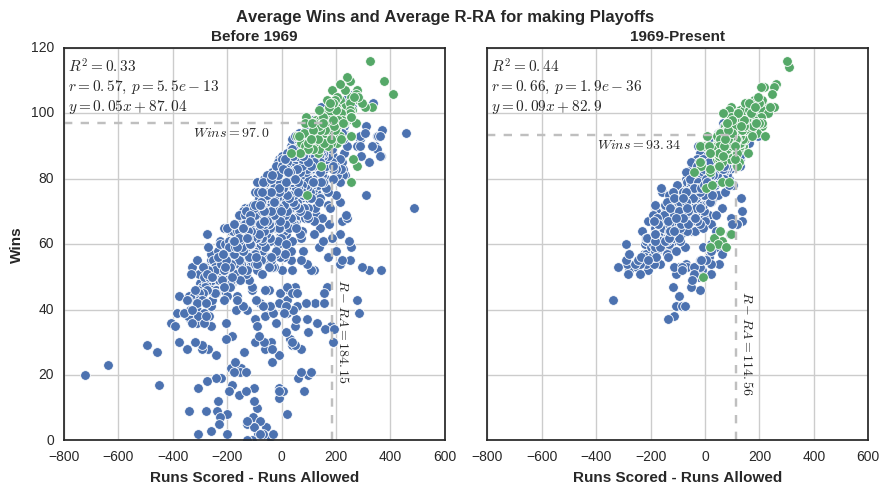

In [45]:
g = sns.FacetGrid(data=teams, col='ps_format_period', col_wrap=2, hue='playoffs')
g.map(plt.plot, 'R-RA', 'W', marker='o', linestyle='None', mec='w', mew=0.6)

g.fig.set_size_inches((9,5))
g.fig.suptitle("Average Wins and Average R-RA for making Playoffs", weight='bold', fontsize=12)
g.set_ylabels('Wins', weight='bold')
g.set_xlabels('Runs Scored - Runs Allowed', weight='bold')
sns.despine(top=False, right=False)

periods = teams.ps_format_period.unique()

for i, ax in enumerate(g.axes.flatten()):
    mask = (teams.ps_format_period == periods[i]) & (teams.playoffs == 1)
    d = teams[mask]
    ax.set_title(periods[i], weight='bold', fontsize=11)
    ax.grid()
    
    # Linear regression using scipy.stats
    mask = ~pd.isnull(d['W']) & ~pd.isnull(d['R-RA'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=d['R-RA'][mask],
                                                                   y=d['W'][mask])
    
    #Add regression summary to plots
    ax.text(0.01, 0.97,
            r"$R^2={r}$".format(r='%.2g'%r_value**2) + "\n"
            r"$r={r}, \thinspace p={p}$".format(r='%.2g'%r_value, p='%.2g'%p_value) + "\n" + 
            r"$y={m}x+{c}$".format(m=round(slope,2), c=round(intercept,2)),
            ha='left', va='top',
            transform = ax.transAxes, fontsize=11)
    
    x = round(d['R-RA'].mean(),2)
    y = round(d['W'].mean(),2)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmax = ((x-xlim[0])/(xlim[1]-xlim[0]))
    ymax = ((y-ylim[0])/(ylim[1]-ylim[0]))
    
    ax.axhline(y=y, linestyle='--', xmax=xmax, c='0.75')
    ax.axvline(x=x, linestyle='--', ymax=ymax, c='0.75')
    ax.annotate(s = "$Wins={y}$".format(y=y),
                xy=(x, y), xytext=(-100, -10), textcoords='offset points')
    ax.annotate(s = "$R-RA={x}$".format(x=x),
                xy=(x, y), xytext=(3, -120), textcoords='offset points', rotation=-90)

g.fig.tight_layout(rect=[0, 0, 1, 0.97])

For the post-season format prior to 1969 average wins of the teams which made playoffs is 97 and corresponding difference in runs scored and runs allowed is about 185. Post 1969 values for the same are 94 wins ans 115 runs. Thus, in order to make playoffs, a team has to score 115 more runs than they allowed during the regular season to expect to win 94 games.